<a href="https://colab.research.google.com/github/sizhky/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [16]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 9.91M/9.91M [00:20<00:00, 495kB/s]


Extracting /content/MNIST\raw\train-images-idx3-ubyte.gz to /content/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 47.6kB/s]


Extracting /content/MNIST\raw\train-labels-idx1-ubyte.gz to /content/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 225kB/s]


Extracting /content/MNIST\raw\t10k-images-idx3-ubyte.gz to /content/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting /content/MNIST\raw\t10k-labels-idx1-ubyte.gz to /content/MNIST\raw



In [22]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn as nn
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [32]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [33]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └

In [34]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  trn_loss: 0.257  val_loss: 0.194  (13.62s - 54.48s remaining)
EPOCH: 2.000  trn_loss: 0.181  val_loss: 0.169  (27.27s - 40.90s remaining)
EPOCH: 3.000  trn_loss: 0.163  val_loss: 0.158  (41.00s - 27.34s remaining)
EPOCH: 4.000  trn_loss: 0.155  val_loss: 0.152  (54.71s - 13.68s remaining)
EPOCH: 5.000  trn_loss: 0.150  val_loss: 0.148  (68.42s - 0.00s remaining)


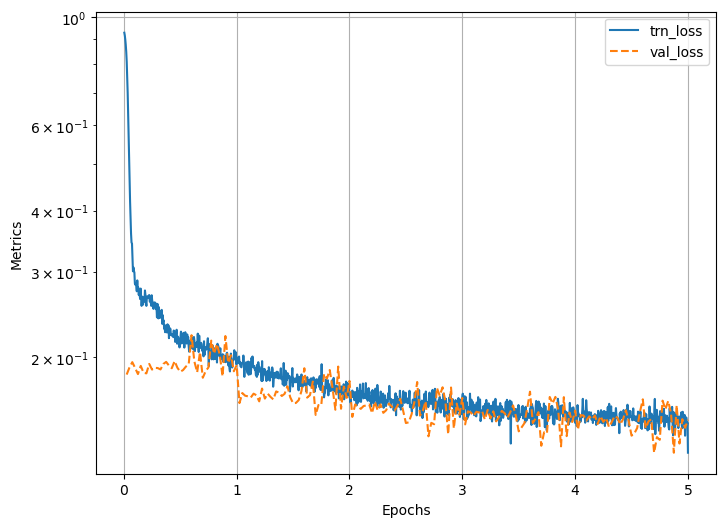

In [38]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5

from torch_snippets.torch_loader import Report
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

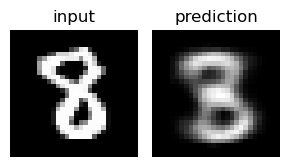

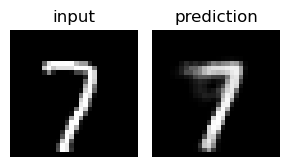

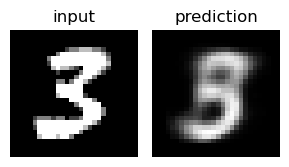

In [42]:
import matplotlib.pyplot as plt;

for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  trn_loss: 0.234  val_loss: 0.135  (13.63s - 54.53s remaining)
EPOCH: 2.000  trn_loss: 0.114  val_loss: 0.099  (27.40s - 41.09s remaining)
EPOCH: 3.000  trn_loss: 0.090  val_loss: 0.080  (40.96s - 27.30s remaining)
EPOCH: 4.000  trn_loss: 0.078  val_loss: 0.071  (54.47s - 13.62s remaining)
EPOCH: 5.000  trn_loss: 0.070  val_loss: 0.066  (67.90s - 0.00s remaining)


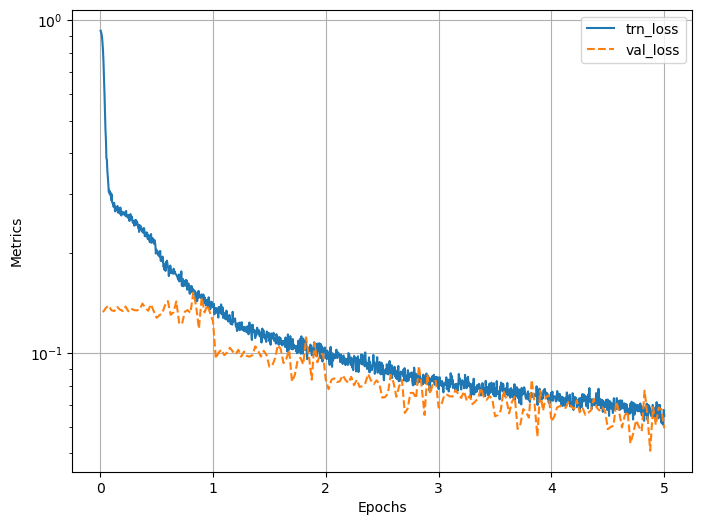

EPOCH: 1.000  trn_loss: 0.268  val_loss: 0.212  (13.70s - 54.78s remaining)
EPOCH: 2.000  trn_loss: 0.203  val_loss: 0.195  (27.34s - 41.01s remaining)
EPOCH: 3.000  trn_loss: 0.190  val_loss: 0.185  (41.03s - 27.35s remaining)
EPOCH: 4.000  trn_loss: 0.182  val_loss: 0.180  (54.64s - 13.66s remaining)
EPOCH: 5.000  trn_loss: 0.177  val_loss: 0.176  (70.14s - 0.00s remaining)


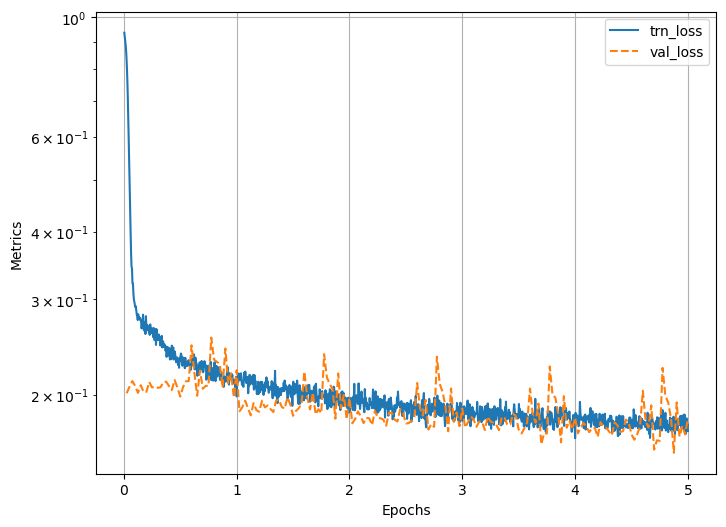

EPOCH: 1.000  trn_loss: 0.263  val_loss: 0.195  (14.49s - 57.96s remaining)
EPOCH: 2.000  trn_loss: 0.182  val_loss: 0.170  (28.44s - 42.65s remaining)
EPOCH: 3.000  trn_loss: 0.164  val_loss: 0.158  (41.97s - 27.98s remaining)
EPOCH: 4.000  trn_loss: 0.155  val_loss: 0.152  (55.56s - 13.89s remaining)
EPOCH: 5.000  trn_loss: 0.150  val_loss: 0.148  (69.23s - 0.00s remaining)


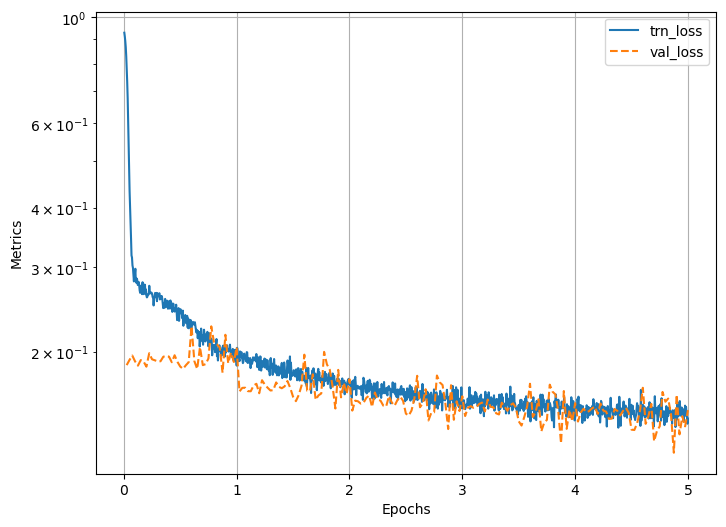

EPOCH: 1.000  trn_loss: 0.261  val_loss: 0.177  (13.66s - 54.66s remaining)
EPOCH: 2.000  trn_loss: 0.158  val_loss: 0.144  (27.24s - 40.87s remaining)
EPOCH: 3.000  trn_loss: 0.138  val_loss: 0.131  (40.70s - 27.14s remaining)
EPOCH: 4.000  trn_loss: 0.129  val_loss: 0.125  (54.18s - 13.55s remaining)
EPOCH: 5.000  trn_loss: 0.124  val_loss: 0.122  (67.88s - 0.00s remaining)


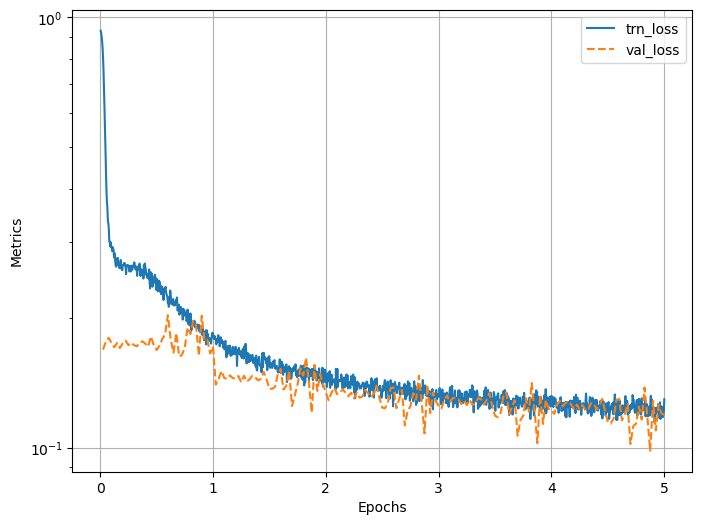

EPOCH: 1.000  trn_loss: 0.233  val_loss: 0.145  (13.51s - 54.04s remaining)
EPOCH: 2.000  trn_loss: 0.127  val_loss: 0.113  (27.15s - 40.72s remaining)
EPOCH: 3.000  trn_loss: 0.109  val_loss: 0.103  (40.53s - 27.02s remaining)
EPOCH: 4.000  trn_loss: 0.102  val_loss: 0.098  (53.93s - 13.48s remaining)
EPOCH: 5.000  trn_loss: 0.097  val_loss: 0.094  (67.34s - 0.00s remaining)


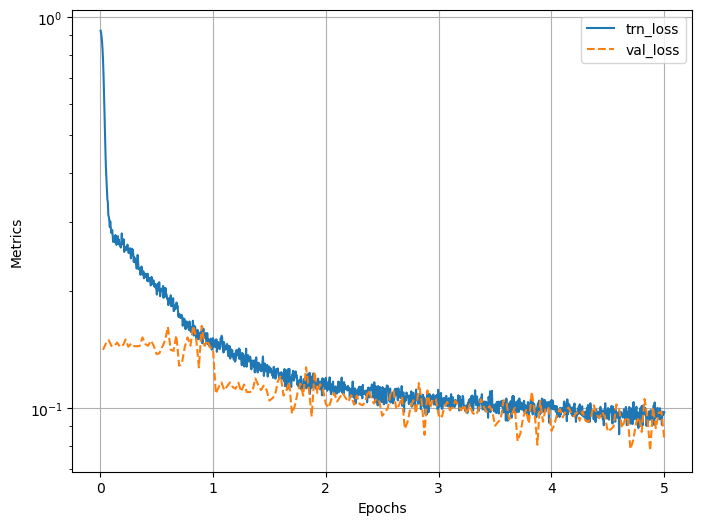

In [43]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

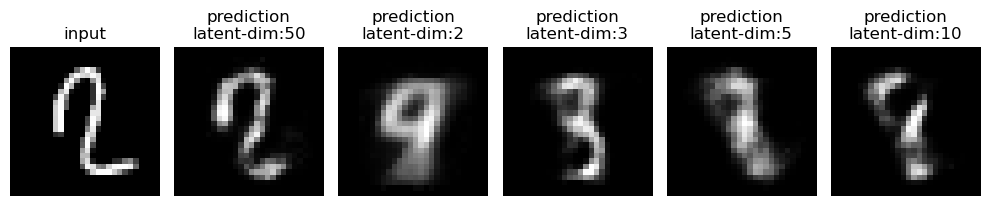

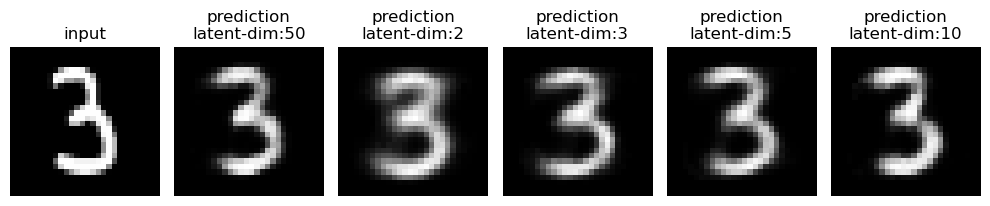

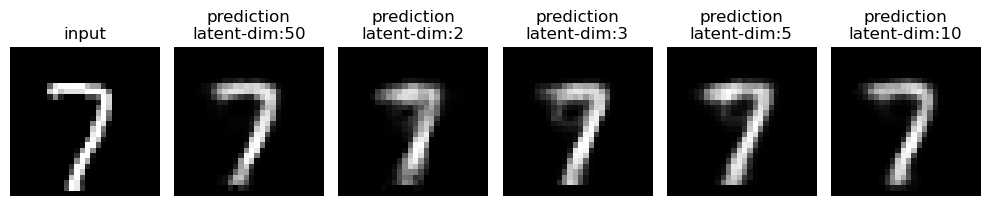

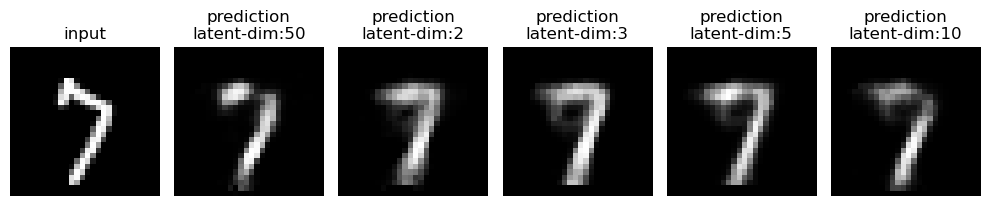

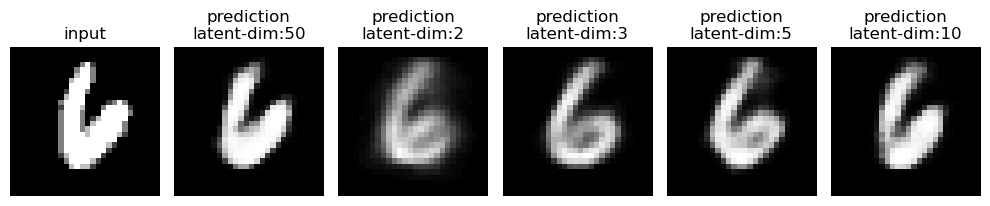

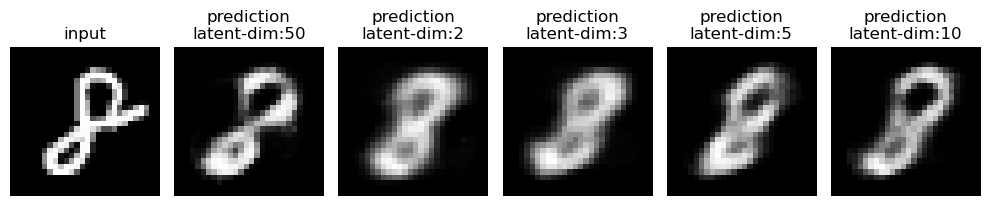

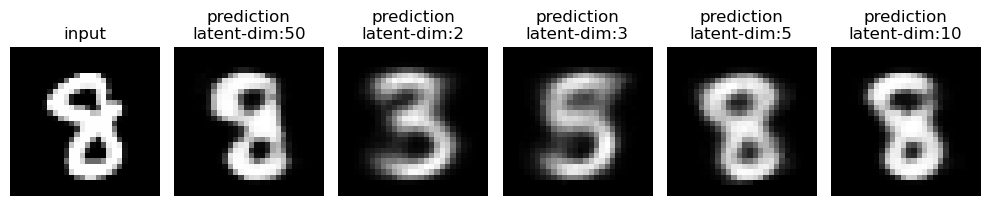

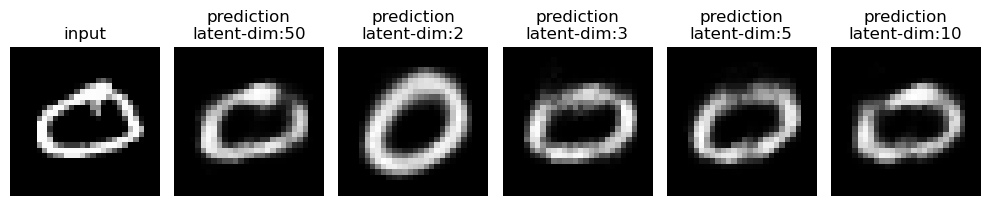

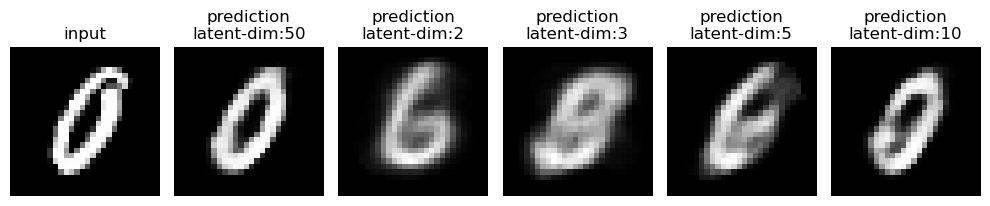

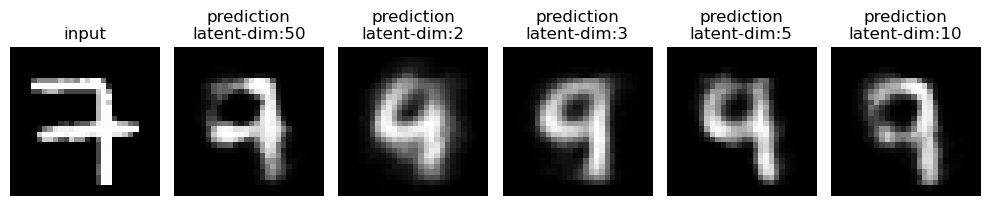

In [44]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()